In [1]:
import torch
import numpy as np
from matplotlib import pyplot as plt
import torch.nn as nn
import torch.optim as optim

In [3]:
load_path = "/data/user/tourist/mixed-percision-quantization-for-SwinIR/scripts/x.pt"


x = torch.load(load_path)
x > 0

/tmp/ipykernel_2501777/986204742.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x = torch.load(load_path)


tensor([[[ True,  True,  True,  ...,  True,  True, False],
         [ True,  True,  True,  ...,  True,  True, False],
         [ True,  True,  True,  ...,  True,  True, False],
         ...,
         [ True,  True,  True,  ...,  True,  True, False],
         [ True,  True,  True,  ...,  True,  True, False],
         [ True,  True,  True,  ...,  True,  True, False]],

        [[ True, False,  True,  ...,  True,  True, False],
         [ True, False,  True,  ...,  True,  True, False],
         [ True, False,  True,  ...,  True,  True, False],
         ...,
         [ True, False,  True,  ...,  True,  True, False],
         [ True, False,  True,  ...,  True,  True, False],
         [ True, False,  True,  ...,  True,  True, False]],

        [[False,  True,  True,  ...,  True,  True, False],
         [False,  True,  True,  ...,  True,  True, False],
         [False,  True,  True,  ...,  True,  True, False],
         ...,
         [False,  True,  True,  ...,  True,  True, False],
         [

In [4]:
loadd_path = "/data/user/tourist/mixed-percision-quantization-for-SwinIR/scripts/xweight.pt"
weight = torch.load(loadd_path)


/tmp/ipykernel_2501777/1790469469.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  weight = torch.load(loadd_path)


In [10]:

def draw_plot(weight):
    weight = torch.abs(weight)
    if weight.is_cuda:
        weight = weight.detach().cpu().numpy()
    else:
        weight = weight.numpy()

    input_channels = weight.shape[0]
    output_channels = weight.shape[1]

    X = np.arange(output_channels)
    Y = np.arange(input_channels)
    print(output_channels)
    print(input_channels)
    X, Y = np.meshgrid(X, Y)

    fig = plt.figure(dpi=100)
    ax = fig.add_subplot(111, projection='3d')

    top_1_percent_threshold = np.percentile(weight, 99)
    # 创建颜色数组，初始化为蓝色，shape 为 (n, 4) 表示 RGBA 值
    colors = np.zeros((weight.size, 4))

    colors[:] = [0, 0, 1, 0.3]  # 蓝色

    top_1_indices = weight.ravel() >= top_1_percent_threshold
    colors[top_1_indices] = [1, 0, 0, 0.8]  # 红色

    ax.bar3d(Y.ravel(), X.ravel(), np.zeros_like(X.ravel()), 0.2, 0.2, weight.ravel(), color=colors)

    ax.set_xlabel('Channel')
    ax.set_ylabel('')
    ax.set_zlabel('Magnitude')

    ax.grid(True)
    ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
    ax.tick_params(axis='y', which='both', bottom=False, top=False, labelleft=False)



    ax.text2D(0.05, 0.95, "X", transform=ax.transAxes, fontsize=15, weight='bold')
    plt.title(f'input_sampled', fontsize=12)


    plt.show()

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (131072,) and arg 5 with shape (7864320,).

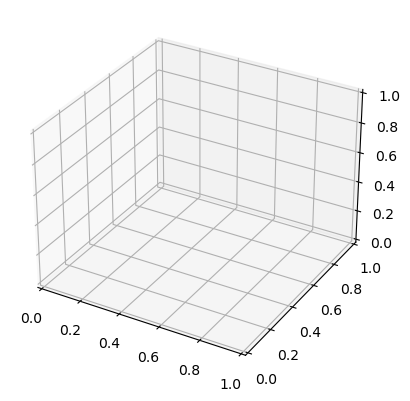

In [6]:
draw_plot(x)

60
180


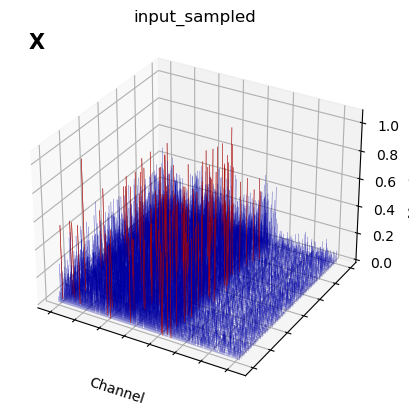

In [11]:
draw_plot(weight)

In [6]:
def uniformity_loss(X):
    return torch.var(X)

def lp_loss(pred, tgt, p=2.0):
    return (pred-tgt).abs().pow(p).mean()
def mse_loss(X, Y):
    return lp_loss(X, Y)

def orth_loss(X, Y):
    I = torch.eye(X.size(0), device=X.device)
    return lp_loss(X @ Y , I)


In [7]:
def quantize(x, max, min):
    n_bits = 2
    delta = (max - min) / (2 ** n_bits - 1)
    zero_point = (- min / delta).round()
    x_int = torch.round(x / delta)
    x_quant = torch.clamp(x_int + zero_point, 0, 2 ** n_bits - 1)
    x_float_q = (x_quant - zero_point) * delta
    return x_float_q

In [8]:
def _quantize(x):
    n_bits = 2
    x_clone = x.clone().detach()
    x_max = x_clone.max()
    x_min = x_clone.min()
    best_score = 1e+10
    best_delta = None
    best_zp = None
    delta = (x_max - x_min) / (2 ** n_bits - 1)
    zero_point = (- x_min / delta).round()
    for pct in [0.9, 0.99, 0.999, 0.9999, 0.99999]:
        try:
            new_max = torch.quantile(x_clone.reshape(-1), pct)
            new_min = torch.quantile(x_clone.reshape(-1), 1.0 - pct)
        except:
            new_max = torch.tensor(np.percentile(
                x_clone.reshape(-1).cpu(), pct * 100),
                device=x_clone.device,
                dtype=torch.float32)
            new_min = torch.tensor(np.percentile(
                x_clone.reshape(-1).cpu(), (1 - pct) * 100),
                device=x_clone.device,
                dtype=torch.float32)   

        x_q = quantize(x_clone, new_max, new_min)
        score = lp_loss(x_clone, x_q, p=2)

        if score < best_score:
            best_score = score
            best_delta = (new_max - new_min) / (2 ** n_bits - 1)
            best_zp = (- new_min / delta).round()

    x_int = torch.round(x / best_delta) + best_zp
    x_quant = torch.clamp(x_int, 0, 2 ** n_bits - 1)
    x_dequant = (x_quant - best_zp) * best_delta

    return x_dequant

In [305]:
def compute_total_loss(X,W, A, B):
    # 计算 XA

    A = A.cuda()
    B = B.cuda()
    origin = torch.matmul(X, W)

    XA = torch.matmul(X, A)
    #BW = torch.matmul(B, weight)
    BW = torch.matmul(B, weight)
   
    uniform_loss = uniformity_loss(XA) * 2 + uniformity_loss(BW)
    xa = _quantize(XA)
    bw = _quantize(BW)

    mseloss = mse_loss(xa @ bw, origin)

    orthloss = orth_loss(A, B)
    
    total_loss =  uniform_loss * 1.5 + orthloss*80 + mseloss * 3
    return total_loss, orthloss, mseloss, uniform_loss


In [320]:


def initialize_orthogonal_matrix(size):
    q, _ = torch.qr(torch.randn(size, size))
    return nn.Parameter(q)


A = initialize_orthogonal_matrix(60, weight.device)
B = initialize_orthogonal_matrix(60, weight.device)

optimizer = optim.Adam([A, B], lr=0.02)
epochs = 100

ModuleNotFoundError: No module named 'utils'

In [312]:
for epoch in range(epochs):
    optimizer.zero_grad()

    # 计算总损失
    total_loss, orth, mmse, uni = compute_total_loss(x, weight, A, B)
    
    # 反向传播和优化
    total_loss.backward()
    optimizer.step()
    
    # 打印损失
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Total Loss: {total_loss.item()}, orth Loss: {orth.item()}, quant_mse Loss: {mmse.item()}, Uniform Loss: {uni.item()}")

Epoch 0, Total Loss: 10.510883331298828, orth Loss: 0.03334468603134155, quant_mse Loss: 2.152209520339966, Uniform Loss: 0.9244528412818909
Epoch 10, Total Loss: 5.448162078857422, orth Loss: 0.004565734416246414, quant_mse Loss: 1.6435354948043823, Uniform Loss: 0.10153130441904068
Epoch 20, Total Loss: 4.816518306732178, orth Loss: 0.0018323316471651196, quant_mse Loss: 1.5234684944152832, Uniform Loss: 0.06635096669197083
Epoch 30, Total Loss: 3.6968042850494385, orth Loss: 0.0009486101916991174, quant_mse Loss: 1.1831252574920654, Uniform Loss: 0.04769311845302582
Epoch 40, Total Loss: 4.326234817504883, orth Loss: 0.0006317884544841945, quant_mse Loss: 1.4081974029541016, Uniform Loss: 0.03406646102666855
Epoch 50, Total Loss: 4.337849140167236, orth Loss: 0.0004265829629730433, quant_mse Loss: 1.4198614358901978, Uniform Loss: 0.029425418004393578
Epoch 60, Total Loss: 4.165736675262451, orth Loss: 0.00035857310285791755, quant_mse Loss: 1.3666362762451172, Uniform Loss: 0.02476

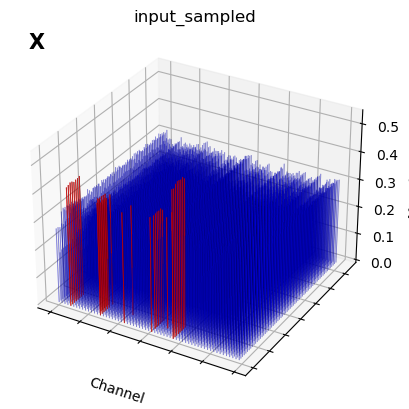

In [313]:

draw_plot(x @ A.cuda())

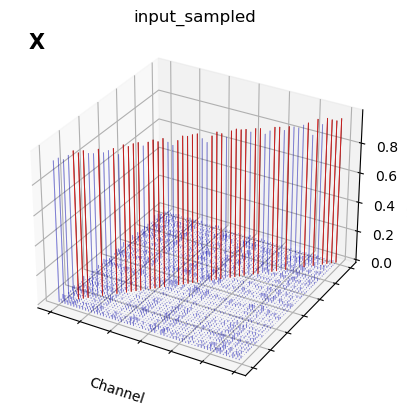

tensor([[ 9.4197e-01, -1.4593e-02, -4.2782e-02,  ..., -3.0845e-02,
          7.4930e-03,  8.0226e-03],
        [-9.4371e-03,  9.5522e-01, -1.3409e-02,  ..., -1.1126e-02,
          2.4272e-02,  1.7297e-02],
        [-3.0741e-02, -2.4407e-03,  9.4126e-01,  ..., -2.4311e-02,
          1.5024e-02, -2.9039e-04],
        ...,
        [-8.2431e-03, -1.1871e-02, -7.3050e-03,  ...,  9.7936e-01,
          9.8497e-03,  4.5618e-03],
        [-2.6079e-03,  1.5580e-02,  8.6412e-03,  ...,  1.5884e-03,
          9.6893e-01, -3.6934e-03],
        [ 4.5806e-03,  1.0830e-02,  1.0190e-02,  ...,  5.0730e-03,
         -7.8517e-03,  9.7972e-01]], device='cuda:0', grad_fn=<MmBackward0>)

In [314]:
s = A.cuda() @ B.cuda()
draw_plot(s)
s

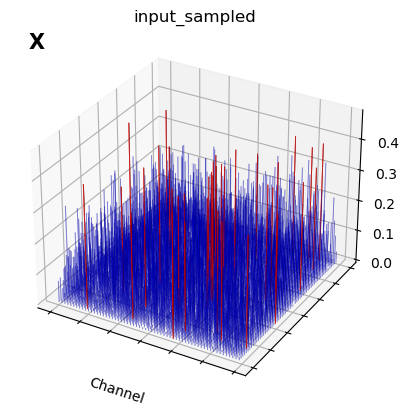

In [315]:
draw_plot(B.cuda() @ weight)

In [1]:
import os
from tqdm import tqdm
import torch
import torch.nn as nn

from torchvision import transforms
from torchvision.utils import save_image
from torchvision.datasets import MNIST

In [2]:
class VAE(nn.Module):
  def __init__(self, in_features, latent_feature, y_size = 0):
    super(VAE, self).__init__()

    self.latent_size = latent_feature

    self.encoder_forward = nn.Sequential(
        nn.Linear(in_features + y_size, in_features),
        nn.LeakyReLU(),
        nn.Linear(in_features, in_features),
        nn.LeakyReLU(),
        nn.Linear(in_features, self.latent_size * 2)
    )

    self.decoder_forward = nn.Sequential(
        nn.Linear(self.latent_size + y_size, in_features),
        nn.LeakyReLU(),
        nn.Linear(in_features, in_features),
        nn.LeakyReLU(),
        nn.Linear(in_features, in_features),
        nn.Sigmoid()
    )

  def encoder(self, X):
    out = self.encoder_forward(X)
    mu = out[:, :self.latent_size]
    log_var = out[:, self.latent_size:]
    return mu, log_var

  def decoder(self, z):
    mu_prime = self.decoder_forward(z)
    return mu_prime

  def reparameterization(self, mu, log_var):
    epsilon = torch.randn_like(log_var)
    z = mu + epsilon * torch.sqrt(log_var.exp())
    return z

  def loss(self, X, mu_prime, mu, log_var):
    reconstruction_loss = torch.mean(torch.square(X - mu_prime).sum(dim=1))

    latent_loss = torch.mean(0.5 * (log_var.exp() + torch.square(mu) - log_var).sum(dim=1))

    return reconstruction_loss + latent_loss

  def forward(self, X, *args, **kwargs):
    mu, log_var = self.encoder(X)
    z = self.reparameterization(mu, log_var)
    mu_prime = self.decoder(z)
    return mu_prime, mu, log_var

In [3]:
def train(model, optimizer, data_loader, device, name='VAE'):
  model.train()

  total_loss = 0
  pbar = tqdm(data_loader)
  for X, y in pbar:
    batch_size = X.shape[0]
    X = X.view(batch_size, -1).to(device)
    model.zero_grad()

    mu_prime, mu, log_var = model(X)

    loss = model.loss(X, mu_prime, mu, log_var)

    loss.backward()
    optimizer.step()

    total_loss += loss.item()
    pbar.set_description('Loss: {loss:.4f}'.format(loss=loss.item()))

  return total_loss / len(data_loader)

In [19]:
@torch.no_grad()
def save_res(vae, data, latent_size, device):
    num_classes = len(data.classes)

    # raw samples from dataset
    save_directory = '/data/user/tourist/mixed-percision-quantization-for-SwinIR/img'
    os.makedirs(save_directory, exist_ok=True)
    out = []
    for i in range(num_classes):
        img = data.data[torch.where(data.targets == i)[0][:num_classes]]
        out.append(img)
    out = torch.stack(out).transpose(0, 1).reshape(-1, 1, 28, 28)
    save_image(out.float(), './img/raw_samples.png', nrow=num_classes, normalize=True)

    # samples generated by vanilla VAE
    z = torch.randn(num_classes ** 2, latent_size).to(device)
    out = vae.decoder(z)
    save_image(out.view(-1, 1, 28, 28), './img/vae_samples.png', nrow=num_classes)

    

In [21]:
def main():
  device = 'cuda' if torch.cuda.is_available() else 'cpu'
  device = torch.device(device)

  batch_size = 256 * 4
  epochs = 50
  latent_size = 60
  in_features = 28 ** 2
  lr = 1e-3

  data = MNIST('', download=True, transform=transforms.ToTensor())
  data_loader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True)

  vae = VAE(in_features, latent_size).to(device)
  optimizer = torch.optim.AdamW(vae.parameters(), lr=lr)

  print('start training VAE')
  for epoch in range(epochs):
    loss = train(vae, optimizer, data_loader, device, name='vae')
    print(f"epochs:{epoch}, AvgLoss: {loss:.4f}")
  print('training VAE done')
  save_res(vae, data, latent_size, device)

In [16]:
os.environ['CUDA_VISIBLE_DEVICES'] = "2"

In [22]:
if __name__ == '__main__':
  main()

start training VAE


Loss: 81.9762: 100%|██████████| 59/59 [00:05<00:00, 11.51it/s]


epochs:0, AvgLoss: 91.0884


Loss: 79.9046: 100%|██████████| 59/59 [00:04<00:00, 12.59it/s]


epochs:1, AvgLoss: 80.8291


Loss: 78.4111: 100%|██████████| 59/59 [00:04<00:00, 13.19it/s]


epochs:2, AvgLoss: 78.7079


Loss: 75.1727: 100%|██████████| 59/59 [00:04<00:00, 13.01it/s]


epochs:3, AvgLoss: 77.0870


Loss: 72.6178: 100%|██████████| 59/59 [00:04<00:00, 12.82it/s]


epochs:4, AvgLoss: 73.9275


Loss: 68.8374: 100%|██████████| 59/59 [00:04<00:00, 12.94it/s]


epochs:5, AvgLoss: 69.7474


Loss: 66.1390: 100%|██████████| 59/59 [00:04<00:00, 12.36it/s]


epochs:6, AvgLoss: 66.8751


Loss: 63.9143: 100%|██████████| 59/59 [00:04<00:00, 12.90it/s]


epochs:7, AvgLoss: 64.9249


Loss: 63.2306: 100%|██████████| 59/59 [00:04<00:00, 12.68it/s]


epochs:8, AvgLoss: 63.6562


Loss: 61.4381: 100%|██████████| 59/59 [00:04<00:00, 12.89it/s]


epochs:9, AvgLoss: 62.7319


Loss: 62.1225: 100%|██████████| 59/59 [00:04<00:00, 12.52it/s]


epochs:10, AvgLoss: 62.0441


Loss: 60.6928: 100%|██████████| 59/59 [00:04<00:00, 12.33it/s]


epochs:11, AvgLoss: 61.5513


Loss: 60.4676: 100%|██████████| 59/59 [00:05<00:00, 11.66it/s]


epochs:12, AvgLoss: 61.1455


Loss: 61.1041: 100%|██████████| 59/59 [00:04<00:00, 12.11it/s]


epochs:13, AvgLoss: 60.8564


Loss: 59.9465: 100%|██████████| 59/59 [00:04<00:00, 13.00it/s]


epochs:14, AvgLoss: 60.6196


Loss: 59.8814: 100%|██████████| 59/59 [00:04<00:00, 13.00it/s]


epochs:15, AvgLoss: 60.3499


Loss: 59.6699: 100%|██████████| 59/59 [00:04<00:00, 13.20it/s]


epochs:16, AvgLoss: 60.1670


Loss: 59.7001: 100%|██████████| 59/59 [00:04<00:00, 12.51it/s]


epochs:17, AvgLoss: 59.9947


Loss: 59.6442: 100%|██████████| 59/59 [00:04<00:00, 12.51it/s]


epochs:18, AvgLoss: 59.8091


Loss: 59.8372: 100%|██████████| 59/59 [00:04<00:00, 12.98it/s]


epochs:19, AvgLoss: 59.6310


Loss: 59.1458: 100%|██████████| 59/59 [00:04<00:00, 12.72it/s]


epochs:20, AvgLoss: 59.4924


Loss: 59.4851: 100%|██████████| 59/59 [00:04<00:00, 12.00it/s]


epochs:21, AvgLoss: 59.3721


Loss: 58.9961: 100%|██████████| 59/59 [00:04<00:00, 12.03it/s]


epochs:22, AvgLoss: 59.2384


Loss: 58.1568: 100%|██████████| 59/59 [00:04<00:00, 11.81it/s]


epochs:23, AvgLoss: 59.1036


Loss: 58.8643: 100%|██████████| 59/59 [00:05<00:00, 11.38it/s]


epochs:24, AvgLoss: 59.0108


Loss: 58.9243: 100%|██████████| 59/59 [00:05<00:00, 11.57it/s]


epochs:25, AvgLoss: 58.8828


Loss: 57.9130: 100%|██████████| 59/59 [00:05<00:00, 11.74it/s]


epochs:26, AvgLoss: 58.7841


Loss: 58.6215: 100%|██████████| 59/59 [00:04<00:00, 11.86it/s]


epochs:27, AvgLoss: 58.6951


Loss: 58.0615: 100%|██████████| 59/59 [00:04<00:00, 11.85it/s]


epochs:28, AvgLoss: 58.5726


Loss: 58.7502: 100%|██████████| 59/59 [00:05<00:00, 11.55it/s]


epochs:29, AvgLoss: 58.4428


Loss: 58.3972: 100%|██████████| 59/59 [00:05<00:00, 11.30it/s]


epochs:30, AvgLoss: 58.3796


Loss: 57.8793: 100%|██████████| 59/59 [00:04<00:00, 11.87it/s]


epochs:31, AvgLoss: 58.2886


Loss: 57.9506: 100%|██████████| 59/59 [00:05<00:00, 11.80it/s]


epochs:32, AvgLoss: 58.1703


Loss: 58.0180: 100%|██████████| 59/59 [00:04<00:00, 11.89it/s]


epochs:33, AvgLoss: 58.0720


Loss: 58.3562: 100%|██████████| 59/59 [00:04<00:00, 11.94it/s]


epochs:34, AvgLoss: 57.9906


Loss: 57.8667: 100%|██████████| 59/59 [00:04<00:00, 11.87it/s]


epochs:35, AvgLoss: 57.9354


Loss: 58.2018: 100%|██████████| 59/59 [00:05<00:00, 11.47it/s]


epochs:36, AvgLoss: 57.8805


Loss: 57.8738: 100%|██████████| 59/59 [00:04<00:00, 11.90it/s]


epochs:37, AvgLoss: 57.7922


Loss: 57.7437: 100%|██████████| 59/59 [00:04<00:00, 11.86it/s]


epochs:38, AvgLoss: 57.7242


Loss: 57.0521: 100%|██████████| 59/59 [00:05<00:00, 11.42it/s]


epochs:39, AvgLoss: 57.6627


Loss: 57.8707: 100%|██████████| 59/59 [00:05<00:00, 11.56it/s]


epochs:40, AvgLoss: 57.6583


Loss: 56.9535: 100%|██████████| 59/59 [00:04<00:00, 11.90it/s]


epochs:41, AvgLoss: 57.5429


Loss: 57.2887: 100%|██████████| 59/59 [00:05<00:00, 11.54it/s]


epochs:42, AvgLoss: 57.5192


Loss: 57.3756: 100%|██████████| 59/59 [00:04<00:00, 11.82it/s]


epochs:43, AvgLoss: 57.4421


Loss: 57.9524: 100%|██████████| 59/59 [00:04<00:00, 12.33it/s]


epochs:44, AvgLoss: 57.4006


Loss: 57.5006: 100%|██████████| 59/59 [00:05<00:00, 11.18it/s]


epochs:45, AvgLoss: 57.3731


Loss: 56.8777: 100%|██████████| 59/59 [00:05<00:00, 11.33it/s]


epochs:46, AvgLoss: 57.3140


Loss: 57.3645: 100%|██████████| 59/59 [00:04<00:00, 11.94it/s]


epochs:47, AvgLoss: 57.2461


Loss: 57.7140: 100%|██████████| 59/59 [00:05<00:00, 11.36it/s]


epochs:48, AvgLoss: 57.2082


Loss: 57.5298: 100%|██████████| 59/59 [00:05<00:00, 11.76it/s]


epochs:49, AvgLoss: 57.1663
training VAE done
